# Predict median_housing_value for a census block group called "district"

In [1]:
%matplotlib inline

#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

#get the same results through notebook
np.random.seed(42)

In [2]:
caliH = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')
caliH.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
caliH.shape

(20640, 10)

In [4]:
caliH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
caliH.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
caliH.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## Data wrangling

### Bucketizing some of the features

In [7]:
caliH['new_house_age'] = pd.cut(caliH.housing_median_age, bins=[0, 25, 50, 75, 100], labels=[1, 2, 3, 4])
caliH.sample(n=4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,new_house_age
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND,1
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND,2
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY,3
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN,1


In [8]:
caliH['new_med_inc'] = pd.cut(caliH.median_income, bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
caliH.sample(n=4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,new_house_age,new_med_inc
20512,-121.55,38.59,36.0,435.0,95.0,285.0,90.0,1.2292,69600.0,INLAND,2,1
15568,-117.04,33.09,16.0,4677.0,581.0,1902.0,566.0,6.1834,335600.0,<1H OCEAN,1,5
4047,-118.51,34.14,28.0,6748.0,904.0,2431.0,876.0,12.8879,500001.0,<1H OCEAN,2,5
18127,-122.02,37.34,30.0,1036.0,151.0,467.0,156.0,6.4480,360600.0,<1H OCEAN,2,5


### Creating new features

In [9]:
caliH['ave_bedrooms'] = (caliH.total_bedrooms/caliH.households)
caliH.ave_bedrooms.head()

0    1.023810
1    0.971880
2    1.073446
3    1.073059
4    1.081081
Name: ave_bedrooms, dtype: float64

In [10]:
caliH['ave_rooms'] = (caliH.total_rooms/caliH.households)
caliH.ave_rooms.head()

0    6.984127
1    6.238137
2    8.288136
3    5.817352
4    6.281853
Name: ave_rooms, dtype: float64

In [11]:
caliH['ave_occup'] = (caliH.population/caliH.households)
caliH.ave_occup.head()

0    2.555556
1    2.109842
2    2.802260
3    2.547945
4    2.181467
Name: ave_occup, dtype: float64

### Information on newly created features

In [12]:
caliH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 15 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
new_house_age         20640 non-null category
new_med_inc           20640 non-null category
ave_bedrooms          20433 non-null float64
ave_rooms             20640 non-null float64
ave_occup             20640 non-null float64
dtypes: category(2), float64(12), object(1)
memory usage: 2.1+ MB


### Drop target and original features that have been modified 

In [13]:
caliH1 = caliH.drop(['housing_median_age', 'median_income', 'total_bedrooms', 'total_rooms', 'households'], axis=1)
caliH1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
population            20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
new_house_age         20640 non-null category
new_med_inc           20640 non-null category
ave_bedrooms          20433 non-null float64
ave_rooms             20640 non-null float64
ave_occup             20640 non-null float64
dtypes: category(2), float64(7), object(1)
memory usage: 1.3+ MB


## Data Visualization

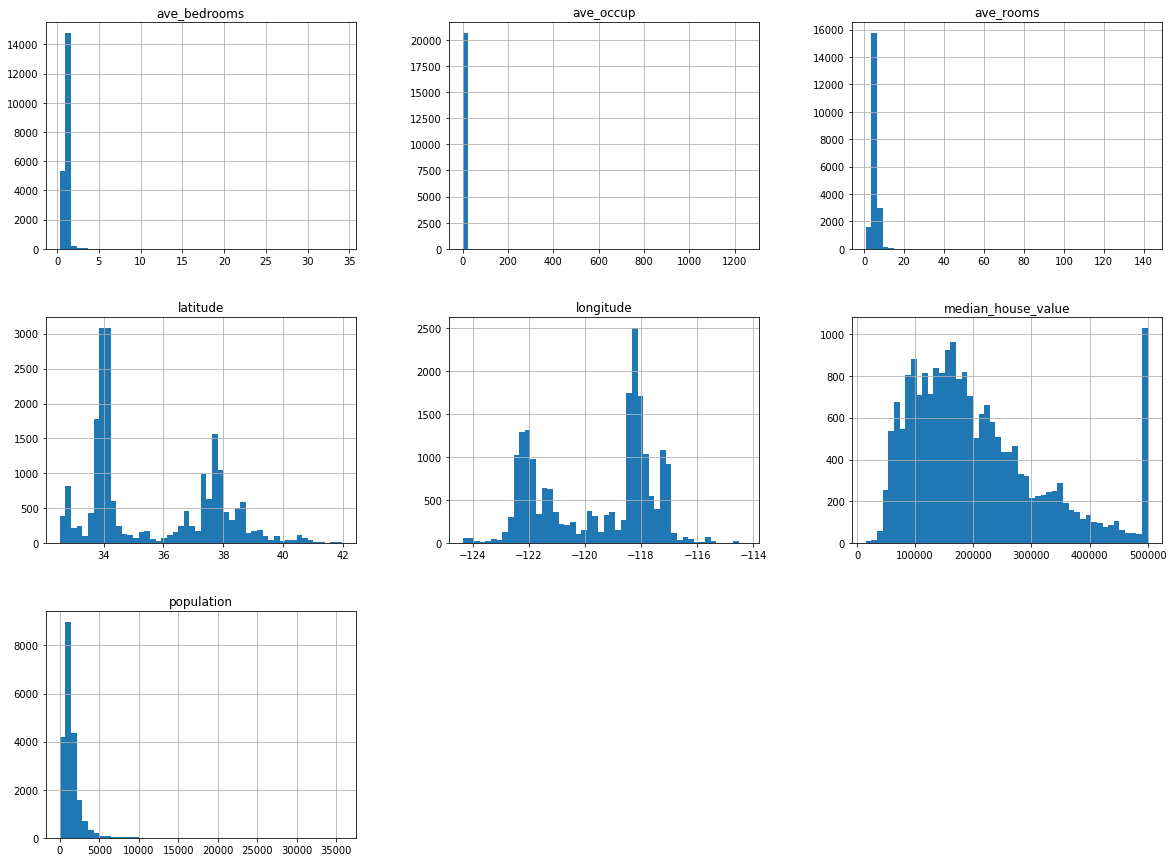

In [14]:
caliH1.hist(bins=50, figsize=(20,15))
plt.show()

## Check for correlations

Text(0.5, 1, 'selecting best features')

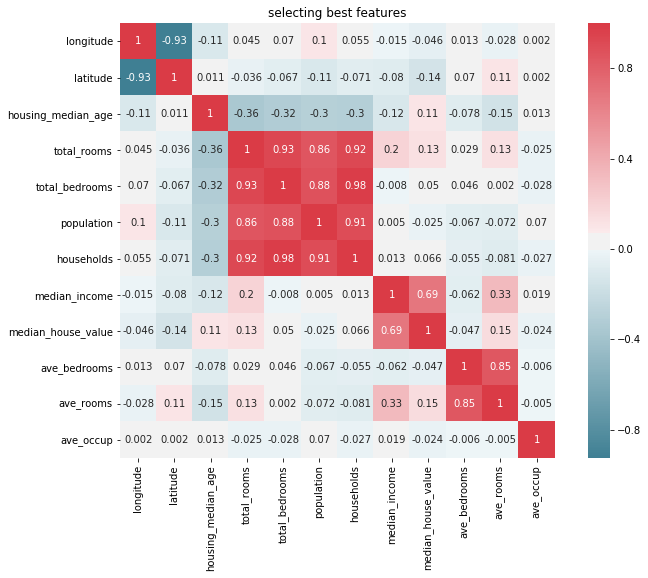

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
corr = caliH.corr().round(3)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True).set_title('selecting best features')

In [16]:
# alternative coorelation coefficient(Pearson's r)
corr_matrix = caliH.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
ave_rooms             0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
ave_occup            -0.023737
population           -0.024650
longitude            -0.045967
ave_bedrooms         -0.046739
latitude             -0.144160
Name: median_house_value, dtype: float64

In [17]:
caliH1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
population            20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
new_house_age         20640 non-null category
new_med_inc           20640 non-null category
ave_bedrooms          20433 non-null float64
ave_rooms             20640 non-null float64
ave_occup             20640 non-null float64
dtypes: category(2), float64(7), object(1)
memory usage: 1.3+ MB


## Preparing the data for training

In [18]:
# make copy of original data
caliH2 = caliH1.copy()

# separating the feature vectors and the target values
X = caliH2.drop('median_house_value', axis =1)
y = caliH2['median_house_value']

X.columns

Index(['longitude', 'latitude', 'population', 'ocean_proximity',
       'new_house_age', 'new_med_inc', 'ave_bedrooms', 'ave_rooms',
       'ave_occup'],
      dtype='object')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(len(X_train), "train +", len(y_test), "test")

16512 train + 4128 test


## Prepare the data for Machine Learning Algorithms
    . Data cleaning
    . Handling categorical and numeric features
    . Transformers
    . Feature scaling
    . Transformation pipelines

In [20]:
# create the preprocessing pipelines for both numeric data
numeric_features = ['longitude', 'latitude', 'ave_bedrooms', 'ave_rooms', 'ave_occup', 'population',
                    'new_house_age', 'new_med_inc']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# create the preprocessing pipelines for both numeric data
categorical_features = ['ocean_proximity']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor process
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

housing_prepared = preprocessor.fit_transform(caliH2)

# Append regressor to preprocessing pipeline
# Now we have a full prediction pipeline
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=100))])          

In [21]:
housing_prepared.shape

(20640, 13)

## Select and train a model

In [22]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(y, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

76419.01639233349

In [25]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y, housing_predictions)
lin_mae

57636.43824351594

In [26]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y, housing_predictions): 
    y, housing_predictions = np.array(y), np.array(housing_predictions)
    return np.mean((np.abs((y - housing_predictions) / y)) * 100)

mape = mean_absolute_percentage_error(y, housing_predictions)
print(mape)

33.117683772280515


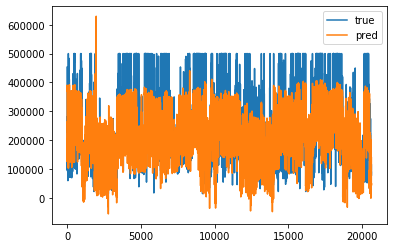

In [27]:
from matplotlib import pyplot as plt

plt.plot(y)
plt.plot(housing_predictions)
plt.legend(["true", "pred"])
plt.show()

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(y, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [30]:
from sklearn.metrics import mean_absolute_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mae = mean_absolute_error(y, housing_predictions)
tree_mae

0.0

In [31]:
from sklearn.utils import check_array
def mean_absolute_percentage_error(y, housing_predictions): 
    y, housing_predictions = np.array(y), np.array(housing_predictions)
    return np.mean((np.abs((y - housing_predictions) / y)) * 100)

mape = mean_absolute_percentage_error(y, housing_predictions)
print(mape)

0.0


In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores) # greater is better

Scores: [125620.16778971  68593.22593041  90324.06381825  70525.46138949
  87992.60014247  82627.74797388  80065.12941825 118511.31408628
 101545.4103077   74432.02930175]
Mean: 90023.71501581979
Standard deviation: 18579.660993211215


## Fine-tune your model
### Grid search

In [33]:
from sklearn.model_selection import GridSearchCV

#param_grid = [
    # try 12 (3×4) combinations of hyperparameters
   # {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 # ]

#forest_reg = RandomForestRegressor()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
#grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           #scoring='neg_mean_squared_error', return_train_score=True)
#grid_search.fit(housing_prepared, y)
param_grid = {'max_depth': np.arange(3, 15)}


dtr_reg = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr_reg, param_grid, cv=5, 
                           error_score='raise-deprecating',
                           return_train_score=False,
                           scoring='neg_mean_squared_error', verbose=0)

grid_search.fit(housing_prepared, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_e

In [34]:
grid_search.best_params_

{'max_depth': 5}

In [35]:
grid_search.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [36]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

79299.60061745673 {'max_depth': 3}
77777.45296330986 {'max_depth': 4}
76405.81249710126 {'max_depth': 5}
79862.90196724307 {'max_depth': 6}
80042.1148365661 {'max_depth': 7}
82623.62007916691 {'max_depth': 8}
87880.33761838905 {'max_depth': 9}
88476.33153727002 {'max_depth': 10}
89761.57568021274 {'max_depth': 11}
88915.66115056806 {'max_depth': 12}
91481.31264441537 {'max_depth': 13}
91299.36514920014 {'max_depth': 14}


## Evaluate your system on the test set

In [37]:
#final_model = grid_search.best_estimator_

#X_test = caliH.drop('median_house_value', axis=1)
#y_test = caliH['median_house_value'].copy()

#X_test_prepared = preprocessor.transform(X_test)

#final_predictions = final_model.predict(X_test_prepared)

#final_mse = mean_squared_error(y_test, final_predictions)
#final_rmse = np.sqrt(final_mse)
#print(final_rmse)

### Randomized Search Cross Validation

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [39]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

72662.6607148894 {'max_features': 7, 'n_estimators': 180}
73461.25950610671 {'max_features': 5, 'n_estimators': 15}
71241.35204010972 {'max_features': 3, 'n_estimators': 72}
73950.06512652188 {'max_features': 5, 'n_estimators': 21}
72548.67749908916 {'max_features': 7, 'n_estimators': 122}
71787.55330805329 {'max_features': 3, 'n_estimators': 75}
71616.74256812637 {'max_features': 3, 'n_estimators': 88}
71518.2282776072 {'max_features': 5, 'n_estimators': 100}
70936.53202032598 {'max_features': 3, 'n_estimators': 150}
87098.18504264558 {'max_features': 5, 'n_estimators': 2}


In [40]:
final_model = grid_search.best_estimator_

X_test = caliH.drop("median_house_value", axis=1)
y_test = caliH["median_house_value"].copy()

X_test_prepared = preprocessor.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

67136.82482293276
